In [1]:
import pandas as pd

# Исходные данные из отчета по портфелю
# Актив Foreign Equity состоит из developed и emerging markets,
# поэтому рассматривая его как портфель из 2 активов и используя корреляцию 0.7395
# между ними отсюда: https://www.longtermtrends.net/emerging-vs-developed-markets/
# получили значения Real expected return = 9,34% и risk = 19.9%
data = [
    ['Absolute Return', 3.5, 7.0, 21.6, 23.5],
    ['Domestic Equity', 6, 17, 2.3, 2.25],
    ['Foreign Equity', 9.34, 19.9, 11.75, 11.75],
    ['Leveraged Buyouts', 8.6, 21.1, 15.8, 17.5],
    ['Natural Resources', 8.5, 24, 3.9, 4.5],
    ['Real Estate', 5.5, 16, 8.6, 9.5],
    ['Venture Capital', 12.3, 37.8 , 13.7, 23.5],
    ['Cash and Fixed Income', 0, 3, 13.7, 7.5]
]

df = pd.DataFrame(data, columns = ['asset', 'return', 'risk', 'weight', 'target_weight'])
df.head 

<bound method NDFrame.head of                    asset  return  risk  weight  target_weight
0        Absolute Return    3.50   7.0   21.60          23.50
1        Domestic Equity    6.00  17.0    2.30           2.25
2         Foreign Equity    9.34  19.9   11.75          11.75
3      Leveraged Buyouts    8.60  21.1   15.80          17.50
4      Natural Resources    8.50  24.0    3.90           4.50
5            Real Estate    5.50  16.0    8.60           9.50
6        Venture Capital   12.30  37.8   13.70          23.50
7  Cash and Fixed Income    0.00   3.0   13.70           7.50>

In [2]:
# Question 2
# Expected return of target portfolio
# Суммируем произведения return и weight каждого актива
exp_return = 0

for index, row in df.iterrows():
    exp_return += row['return'] * row['target_weight']

print(exp_return * 0.0001)

0.07355450000000001


In [3]:
corr_matrix = [
    [1 , 0.6, 0.6, 0.6, 0.1, 0.6, 0.2, 0.1],
    [0, 1, 0.85, 0.8, 0.2, 0.6, 0.4, 0.1],
    [0, 0, 1, 0.65, 0.25, 0.65, 0.4, 0.1],
    [0, 0, 0, 1, 0.1, 0.6, 0.2, 0.1 ],
    [0, 0, 0, 0, 1, 0.1, 0.1, 0.1],
    [0, 0, 0, 0, 0, 1, 0.2, 0.1],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1]
]


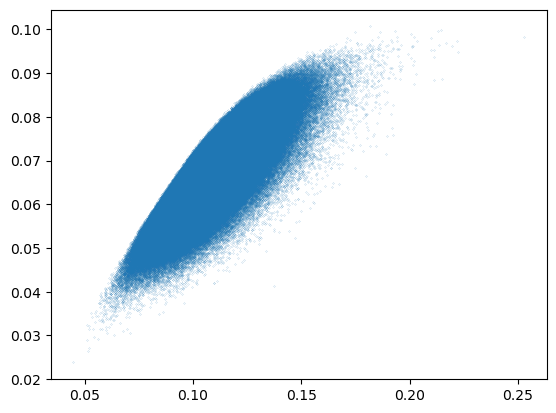

In [4]:
# Question 3
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as solver
from functools import reduce
from math import sqrt

assets_return = df['return'].tolist()
assests_risk = df['risk'].tolist()

# Для данных весов вычисляем expected return
def calculateReturnForWeights(random_weights: list):
    r = 0
    for index, weight in enumerate(random_weights):
        r += weight * assets_return[index] * 0.01
    return r

# Для данных весов вычисляем стандартное отклонение
def calculateVarianceForWeights(random_weights: list, corr_matrix):
    v = 0
    for i, weight in enumerate(random_weights):
        v += (weight * assests_risk[i] * 0.01) ** 2
        for j, corr in enumerate(corr_matrix[i][i + 1:]):
            v += weight * random_weights[j] * corr_matrix[i][j] * assests_risk[i] * assests_risk[j] * 0.0001
    return sqrt(v)

# генерируем веса
def generateRandomWeights():
    random_weights = np.random.random(8)
    random_weights /= random_weights.sum()
    return random_weights

# Генерируем steps случайных комбинаций весов и вычисляем для них expected return и variance
steps = 1000000 # количество точек
return_row = []
variance_row = []
for s in range(1, steps + 1):
    random_weights = generateRandomWeights()
    # получаем два массива expected return и variance
    return_row.append(calculateReturnForWeights(random_weights.tolist()))
    variance_row.append(calculateVarianceForWeights(random_weights.tolist(), corr_matrix))

plt.scatter(variance_row, return_row, s = 0.01)
plt.show()

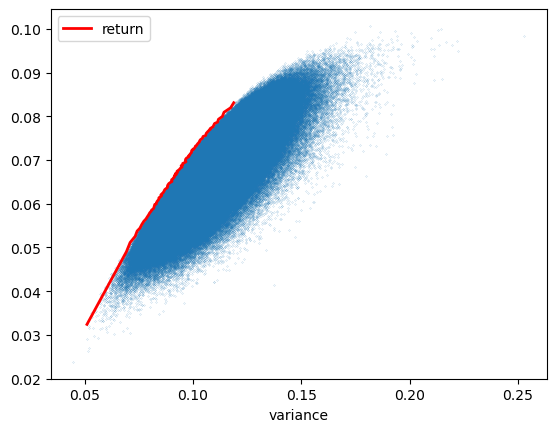

In [5]:
# Получаем efficient frontier
# Для окна шириной delta находим для данных return точку с минимальной variance
# и добавляем ее в dataframe efficient_frontier
df3 = pd.DataFrame(
    {'return': return_row,
     'variance': variance_row
    })

def getEfficientFrontier(df, delta):
    df = df.sort_values('return')
    efficient_frontier = pd.DataFrame(columns = ['return', 'variance'])
    for i in range(1, len(df) - delta, delta):
        sub_df = df[i:i + delta]
        data = sub_df[sub_df['variance'] == sub_df['variance'].min()]
        efficient_frontier = pd.concat([efficient_frontier, data], axis=0)
    return efficient_frontier

efficient_frontier = getEfficientFrontier(df3, 10000)
efficient_frontier.plot(x = "variance", y = "return", linewidth=2.0, color = ['red'], legend = 'efficient frontier')
plt.scatter(variance_row, return_row, s = 0.01)
plt.show()

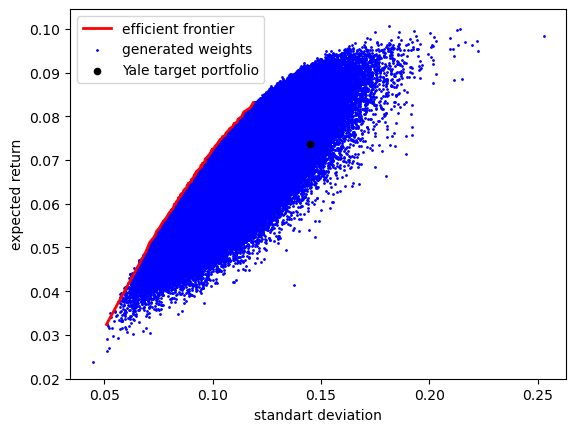

In [21]:
# Question 4

# выполняем вычисления return и stdev (variance) для одной целевых весов портфеля
yale_target_portfolio_weights = df['target_weight'].tolist()
yale_target_portfolio_weights_to_percent = [i * 0.01 for i in yale_target_portfolio_weights]

efficient_frontier.plot(x = "variance", y = "return", linewidth=2.0, color = ['red'])
plt.scatter(variance_row, return_row, s = 1, color = 'blue')
plt.scatter(
    calculateVarianceForWeights(yale_target_portfolio_weights_to_percent, corr_matrix), 
    calculateReturnForWeights(yale_target_portfolio_weights_to_percent), 
    s = 20,
    color = 'black')
plt.legend(['efficient frontier', 'generated weights', 'Yale target portfolio'])
plt.xlabel('standart deviation')
plt.ylabel('expected return')
plt.show()

0.074 0.102


<Axes: ylabel='asset'>

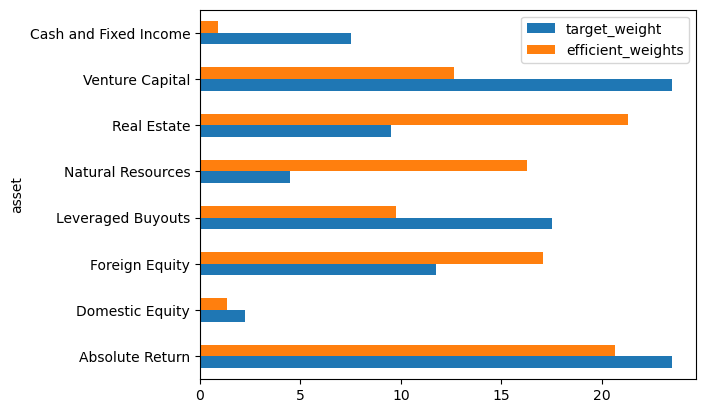

In [7]:
# Question 5

import seaborn as sns

# Находим значения return и stdev для целевых весов портфеля
number_of_digits = 3
target_return = round(calculateReturnForWeights(yale_target_portfolio_weights_to_percent), number_of_digits)
# округляем значения до number_of_digits знаков в наборе точек efficient_frontier 
# и находим самую левую точку с return равным target_return
efficient_frontier_round = efficient_frontier.apply(lambda x: round(x, number_of_digits))
target_variance = efficient_frontier_round.loc[efficient_frontier_round['return'] == round(target_return, number_of_digits)]['variance'].min()
print(target_return, target_variance)
# Генерируем случайные веса
efficient_frontier_yale_weights = []
while True:
    random_weights = np.random.random(8)
    random_weights /= random_weights.sum()
    random_return = round(calculateReturnForWeights(random_weights), number_of_digits)
    doesReturnEquals = (random_return == target_return)
    random_variance = round(calculateVarianceForWeights(random_weights, corr_matrix), number_of_digits)
    doesVarianceEquals = (random_variance == target_variance)
    # Если return и stdev (variance) совпадают с целевыми, считаем этот набор весов подходящим
    if (doesReturnEquals and doesVarianceEquals):
        efficient_frontier_yale_weights = random_weights
        break

# df_efficient_portfolio_comparison - собираем исходные target_weight и полученные в один dataframe
df_epc = df.filter(['asset','target_weight'], axis=1)

efficient_frontier_yale_weights = [round(i * 100, 2) for i in efficient_frontier_yale_weights]
df_epc['efficient_weights'] = pd.Series(efficient_frontier_yale_weights).values
df_epc = df_epc.set_index(df_epc['asset'])
df_epc.plot.barh()

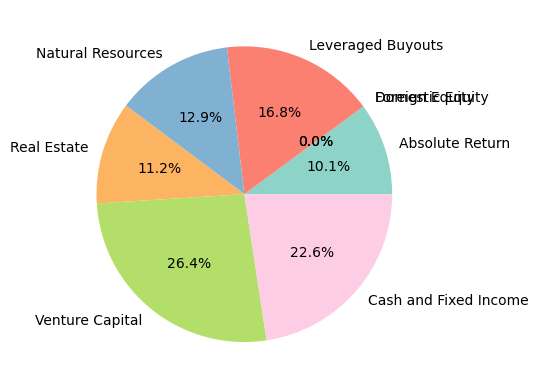

In [8]:
# Question 6

# Чтобы получить диапазон возможных весов для каждого актива нужно решить две задачи:
# 1. Опередлить ширину интервала
# 2. Определить центр интервала, то есть, если ширина - 10%, то это 40-50% или 20-30%?
# Ключевые идеи и предположения:
# 1. Решим 2 задачу для каждого актива с 3 точек зрения: 
#    рассматриваем только диверсификацию, только return/risk, только ликвидность
# 2. Полученные веса сложим с учетом значимости для нас
# 3. Сравним с историческими данными

import seaborn as sns

# Рассматриваем только корреляцию. Идея - чем больше корреляция с другими активами, тем меньше берем актива
full_corr_matrix = [
    [1 , 0.6, 0.6, 0.6, 0.1, 0.6, 0.2, 0.1],
    [0.6, 1, 0.85, 0.8, 0.2, 0.6, 0.4, 0.1],
    [0.6, 0.85, 1, 0.65, 0.25, 0.65, 0.4, 0.1],
    [0.6, 0.8, 0.65, 1, 0.1, 0.6, 0.2, 0.1 ],
    [0.25, 0.2, 0.8, 0.6, 1, 0.1, 0.1, 0.1],
    [0.6, 0.6, 0.65, 0.2, 0.6, 1, 0.2, 0.1],
    [0.2, 0.4, 0.4, 0.1, 0.1, 0.1, 1, 0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 1]
]
asset_names = ['Absolute Return',
               'Domestic Equity', 
               'Foreign Equity', 
               'Leveraged Buyouts', 
               'Natural Resources', 
               'Real Estate', 
               'Venture Capital', 
               'Cash and Fixed Income']
s_matrix = [1, 1, 1, 1, 1, 1, 1, 1]
# решаем уравнение full_corr_matrix * weights = s_matrix и находим веса
corr_values = np.linalg.solve(full_corr_matrix, s_matrix)
corr_distr_to_zero = [0 if x < 0 else x for x in corr_values ]
corr_distr = [i / sum(corr_distr_to_zero) for i in corr_distr_to_zero]
plt.pie(
    corr_distr, 
    labels=asset_names, 
    autopct='%1.1f%%', 
    colors = sns.color_palette('Set3'))
plt.show()


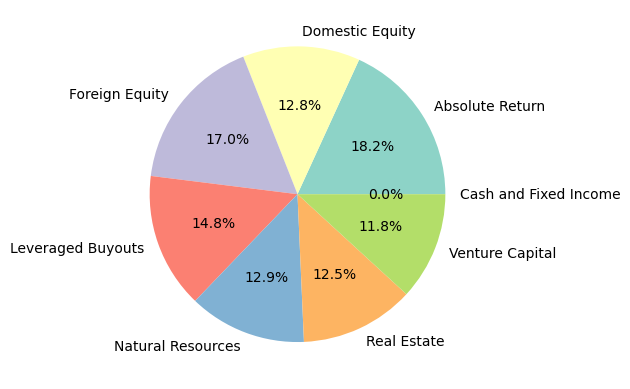

In [9]:
# далее рассматриваем только return/risk
# идея - чем больше return/risk, тем больше берем актива
df_sharp = df.filter(['asset','return', 'risk'], axis=1)
df_sharp['sharp_ratio'] = df_sharp['return'] / df_sharp['risk']
df_sharp['sharp_ratio'] = df_sharp['sharp_ratio'] / df_sharp['sharp_ratio'].sum()
plt.pie(
    df_sharp['sharp_ratio'], 
    labels=df_sharp['asset'],
    autopct='%1.1f%%', 
    colors = sns.color_palette('Set3'))
plt.show()

In [10]:
# указываем в матрице ликвидные (1) и неликвидные активы (2)
liquidity_matrix = [
    ['Absolute Return', 0],
    ['Domestic Equity', 1],
    ['Foreign Equity', 1],
    ['Leveraged Buyouts', 0],
    ['Natural Resources', 1],
    ['Real Estate', 0],
    ['Venture Capital', 1],
    ['Cash and Fixed Income', 1]    
]

# выбираем уровень ликвидности - доля ликвидных активов в портфеле
level_of_liquidity_matrix = 0.2

# вычисляем требуемую долю ликвидных активов для поддержания выбранного уровня
df_liquidity = pd.DataFrame(liquidity_matrix, columns = ['asset', 'liquidity'])
s = df_liquidity['liquidity'].sum()
df_liquidity['liq'] = df_liquidity['liquidity'].apply(lambda x: x * level_of_liquidity_matrix / s)
df_liquidity.head

<bound method NDFrame.head of                    asset  liquidity   liq
0        Absolute Return          0  0.00
1        Domestic Equity          1  0.04
2         Foreign Equity          1  0.04
3      Leveraged Buyouts          0  0.00
4      Natural Resources          1  0.04
5            Real Estate          0  0.00
6        Venture Capital          1  0.04
7  Cash and Fixed Income          1  0.04>

In [11]:
# Собираем веса, полученные только для return/value, диверсификации и ликвидности, в один dataframe
# вычисляем веса активов по формуле asset_weight = w1 * sharp + w2 * corr + w3 * liq,
# где w1, w2, w3 - веса, отображаются значимость для нас, собраны в список sig,
# shar, corr, liq - полученные выше веса

sig = [1, 2, 3] # liq, corr, return/value, последний считаем самым важным
contrain_width = 0.5 # относительная полуширина интервала min-max для веса актива

df_contrains = df_liquidity[['asset', 'liq']].copy()
df_contrains['corr'] = corr_distr
df_contrains['sharp'] = df_sharp['sharp_ratio']

df_contrains['weight'] = sig[0] * df_contrains['liq'] + sig[1] * df_contrains['corr'] + sig[2] * df_contrains['sharp']
df_contrains['weight'] = df_contrains['weight'].apply(lambda x: x / df_contrains['weight'].sum())
df_contrains['min_calc'] = df_contrains['weight'].apply(lambda x: round(x * (1 - contrain_width), 2) * 100)
df_contrains['max_calc'] = df_contrains['weight'].apply(lambda x: round(x * (1 + contrain_width), 2) * 100)

In [12]:
# сравним с историческими данными (2004-2020)
historical_contrains = [
    ['Absolute Return', 14.5, 26.1],
    ['Domestic Equity', 2.3, 5.9],
    ['Foreign Equity', 7.8, 15.3],
    ['Leveraged Buyouts', 14.1, 24.3],
    ['Natural Resources', 3.9, 8.3],
    ['Real Estate', 8.6, 21.7],
    ['Venture Capital', 10, 23.5],
    ['Cash and Fixed Income', 4.5, 13.7]
]

df_calc_and_hist = pd.DataFrame(historical_contrains, columns = ['asset', 'hist_min', 'hist_max'])
df_calc_and_hist['calc_min'] = df_contrains['min_calc']
df_calc_and_hist['calc_max'] = df_contrains['max_calc']

# с удивлением обнаруживаем, что интервалы довольно совпадают
# Резюмируя:
# - посчитали веса портфелей отдельно из соображений оптимальной диверсификации, отношения return/risk, корреляции
# - собрали вместе с весами и получилис интервалы весов
# - самые сомнительные предположения:
#   -- full_corr_matrix * weights = s_matrix : почему s_matrix = 1
#   -- liquidity_matrix - по-хорошему, нужно считать ликвидным только cash, матрицу можно заполнить по-разному, 
#      однако ее влияние на конечный результат минимально
#   -- sig = [1, 2, 3] - влияние можно указать по-разному
#   -- contrain_width = 0.5 - полуширину можно указать по-разному
#   -- в целом, расчеты больше качественные, понятно, что алгоритмы вычисления конкретных точек некорректны
df_calc_and_hist.head


<bound method NDFrame.head of                    asset  hist_min  hist_max  calc_min  calc_max
0        Absolute Return      14.5      26.1       7.0      22.0
1        Domestic Equity       2.3       5.9       4.0      12.0
2         Foreign Equity       7.8      15.3       5.0      16.0
3      Leveraged Buyouts      14.1      24.3       7.0      22.0
4      Natural Resources       3.9       8.3       7.0      20.0
5            Real Estate       8.6      21.7       6.0      17.0
6        Venture Capital      10.0      23.5       9.0      27.0
7  Cash and Fixed Income       4.5      13.7       5.0      14.0>

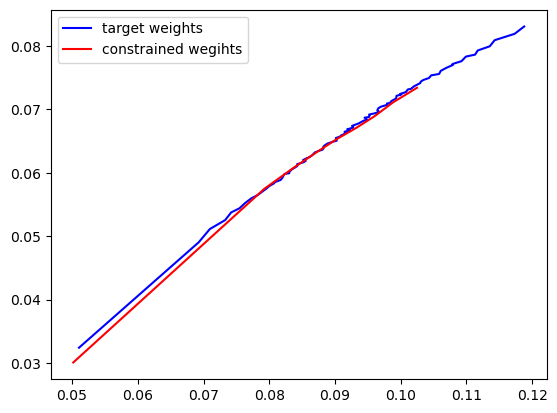

In [13]:
# Question 7

# Foreign Equity, Leveraged Buyouts, Venture Capital - наиболее высокодоходные, наибольшая корреляция
# Absolute Return - beta = 0,  высокая доходность, высокая корреляция
# Natural Resources, Real Estate - не коррелируют и защита от инфляции
# Domestic Equity - низкая доходность, высокая корреляция, берем для диверсификации и ликвидности
# Cash and Fixed Income - для финансирования текущих нужд университета и ликвидности
# Для диверсификации портфеля возьмем: 
# 75% - Foreign Equity, Leveraged Buyouts, Venture Capital, Absolute Return, Domestic Equity
# 25% - Natural Resources, Real Estate, Cash and Fixed Income
# Absolute Return - возьмем 35%, Foreign Equity, Leveraged Buyouts, Venture Capital - по 10%, Domestic Equity - 5%
# Natural Resources, Real Estate - по 5%, Cash and Fixed Income - 15%

constrains = [
    ['Absolute Return', 30, 40],
    ['Domestic Equity', 3, 7],
    ['Foreign Equity', 5, 15],
    ['Leveraged Buyouts', 5, 15],
    ['Natural Resources', 3, 7],
    ['Real Estate', 3, 7],
    ['Venture Capital', 5, 15],
    ['Cash and Fixed Income', 10, 20]
]
df_constrains = pd.DataFrame(constrains, columns = ['asset', 'min', 'max'])

mins = [i * 0.01 for i in df_constrains['min'].tolist()]
maxs = [i * 0.01 for i in df_constrains['max'].tolist()]

def doWeightsMeetConstrains(random_weights):
    r = False
    for index, weight in enumerate(random_weights):
        if weight >= mins[index] and weight <= maxs[index]:
            r = True
    return r

def generateConstrainedWeights():
    random_weights = []
    do_weights_meet = False
    while do_weights_meet != True:        
        random_weights = generateRandomWeights().tolist()
        do_weights_meet = doWeightsMeetConstrains(random_weights)
    return random_weights

steps = 100000 # количество точек
return_row_constrains = []
variance_row_constrains = []
for s in range(1, steps + 1):
    random_weights = generateConstrainedWeights()
    # получаем два массива expected return и variance
    return_row_constrains.append(calculateReturnForWeights(random_weights))
    variance_row_constrains.append(calculateVarianceForWeights(random_weights, corr_matrix))

df7 = pd.DataFrame(
    {'return': return_row,
     'variance': variance_row
    })
df7_ef = getEfficientFrontier(df7, 10000)

df_7_constr = pd.DataFrame(
    {'return': return_row_constrains,
     'variance': variance_row_constrains
    })
df_7_constr_ef = getEfficientFrontier(df_7_constr, 10000)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df7_ef['variance'], df7_ef['return'], label='target weights', color='blue')
ax1.plot(df_7_constr_ef['variance'], df_7_constr_ef['return'], label='constrained wegihts', color='red')
plt.legend(loc='upper left')
plt.show()

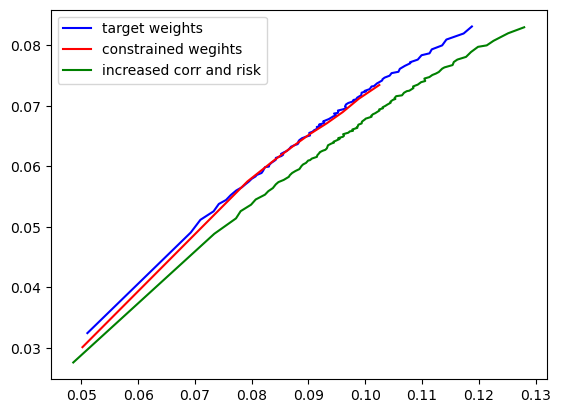

In [14]:
# Question 8

risky_df = df.copy()
risky_df['risk'] = risky_df['risk'] * 1.2
increased_corr_matrix = [[1.05 * v for v in r if v != 1] for r in corr_matrix]
assets_return = risky_df['return'].tolist()
assests_risk = risky_df['risk'].tolist()

# Для данных весов вычисляем expected return
def calculateReturnForWeights(random_weights: list):
    r = 0
    for index, weight in enumerate(random_weights):
        r += weight * assets_return[index] * 0.01
    return r

# Для данных весов вычисляем стандартное отклонение
def calculateVarianceForWeights(random_weights: list, corr_matrix):
    v = 0
    for i, weight in enumerate(random_weights):
        v += (weight * assests_risk[i] * 0.01) ** 2
        for j, corr in enumerate(corr_matrix[i][i + 1:]):
            v += weight * random_weights[j] * corr_matrix[i][j] * assests_risk[i] * assests_risk[j] * 0.0001
    return sqrt(v)

# Генерируем steps случайных комбинаций весов и вычисляем для них expected return и variance
steps = 1000000 # количество точек
risky_return_row = []
risky_variance_row = []
for s in range(1, steps + 1):
    random_weights = generateRandomWeights()
    # получаем два массива expected return и variance
    risky_return_row.append(calculateReturnForWeights(random_weights.tolist()))
    risky_variance_row.append(calculateVarianceForWeights(random_weights.tolist(), increased_corr_matrix))

df8 = pd.DataFrame(
    {'return': risky_return_row,
     'variance': risky_variance_row
    })
df8_ef = getEfficientFrontier(df8, 10000)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df7_ef['variance'], df7_ef['return'], label='target weights', color='blue')
ax1.plot(df_7_constr_ef['variance'], df_7_constr_ef['return'], label='constrained wegihts', color='red')
ax1.plot(df8_ef['variance'], df8_ef['return'], label='increased corr and risk', color='green')
plt.legend(loc='upper left')
plt.show()